# Лабораторная работа № 10. Решение краевой задачи для ОДУ

$$\frac{𝑑^2𝑢(x)}{𝑑𝑥^2}+𝑝(𝑥)\frac{𝑑𝑢(𝑥)}{𝑑𝑥}+𝑞(𝑥)𝑢(𝑥)=𝑓(𝑥),𝑎<𝑥<𝑏$$
$$c_1u(a)+c_2\frac{du(a)}{dx}=c$$
$$d_1u(b)+d_2\frac{du(b)}{dx}=d$$

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def p(x):
    return np.log(x)

def q(x):
    return x ** 2

def f(x):
    return 1 / (1 + x)

In [ ]:
a, b = 1, 3
c1, c2, c = 1, 0.2, 0
d1, d2, d = 0.14, 0.77, 0.17

In [ ]:
def thomas_method(A, b):
    n = A.shape[0]
    x = np.zeros(n)
    alpha = np.zeros(n - 1)
    beta = np.zeros(n)

    alpha[0] = -A[0][1] / A[0][0]
    beta[0] = b[0] / A[0][0]
    for i in range(1, n - 1):
        y = A[i][i] + A[i][i - 1] * alpha[i - 1]
        alpha[i] = - A[i][i + 1] / y
        beta[i] = (b[i] - A[i][i - 1] * beta[i - 1]) / y
    beta[n - 1] = (b[n - 1] - A[n - 1][n - 2] * beta[n - 2]) / (A[n - 1][n - 1] + A[n - 1][n - 2] * alpha[n - 2])

    x[n - 1] = beta[n - 1]
    for i in range(n - 2, -1, -1):
        x[i] = alpha[i] * x[i + 1] + beta[i]

    return x

In [ ]:
def runge_kutta_system(f, g, u0, v0, a, b, N):
    t = np.linspace(a, b, N)
    tau = t[1] - t[0]

    result = np.zeros((2, N))
    result[0, 0] = u0   # Значения u
    result[1, 0] = v0   # Значения v

    y_prev = u0
    w_prev = v0

    for i in range(1, N):
        y, w = get_y_rk_system(f, g, t[i - 1], t[i], result[0, i-1], result[1, i-1])

        result[0, i] = y
        result[1, i] = w

    return result

def get_y_rk_system(f, g, a, b, y_prev, w_prev):
    tau = b - a

    k1_y, k2_y, k3_y, k4_y, k1_w, k2_w, k3_w, k4_w = get_k_system(f, g, tau, a, y_prev, w_prev)

    y = y_prev + (tau/6) * (k1_y + 2*k2_y + 2*k3_y + k4_y)
    w = w_prev + (tau/6) * (k1_w + 2*k2_w + 2*k3_w + k4_w)

    return y, w

def get_k_system(f, g, tau, t, u, v):
    k1_y, k1_w = f(t, u, v), g(t, u, v)
    k2_y, k2_w = f(t + tau/2, u + tau/2 * k1_y, v + tau/2 * k1_w), g(t + tau/2, u + tau/2 * k1_y, v + tau/2 * k1_w)
    k3_y, k3_w = f(t + tau/2, u + tau/2 * k2_y, v + tau/2 * k2_w), g(t + tau/2, u + tau/2 * k2_y, v + tau/2 * k2_w)
    k4_y, k4_w = f(t + tau, u + tau * k3_y, v + tau * k3_w), g(t + tau, u + tau * k3_y, v + tau * k3_w)

    return k1_y, k2_y, k3_y, k4_y, k1_w, k2_w, k3_w, k4_w

# Задание 1
Построить разностную аппроксимацию задачи. Разностную задачу решить методом прогонки.

In [ ]:
def finite_difference_method(p, q, f, a, b, c1, c2, c, d1, d2, d, N):
    grid = np.linspace(a, b, N)
    tau = grid[1] - grid[0]

    A = np.zeros((N, N))
    br = np.zeros((N))

    A[0, 0] = tau * c1 - c2
    A[0, 1] = c2
    br[0] = c * tau
    for i in range(1, N - 1):
        if p(grid[i]) > 0:
            A[i, i - 1] = 1                                           # нижняя диагональ
            A[i, i] = -(2 + tau * p(grid[i]) - tau ** 2 * q(grid[i])) # главная диагональ
            A[i, i + 1] =  1 + tau * p(grid[i])                       # верхняя диагональ
        else:
            A[i, i - 1] = 1 - tau * p(grid[i])                        # нижняя диагональ
            A[i, i] = -(2 - tau * p(grid[i]) - tau ** 2 * q(grid[i])) # главная диагональ
            A[i, i + 1] = 1                                           # верхняя диагональ

        br[i] = tau ** 2 * f(grid[i])
    A[N - 1, N - 2] = -d2
    A[N - 1, N - 1] = tau * d1 + d2
    br[N - 1] = d * tau

    y = thomas_method(A, br)

    return y

# Задание 2
Решить задачу  методом стрельбы

In [ ]:
def g1(x, u, v):
    return f(x) - p(x)*v - q(x)*u

def g2(x, u, v):
    return v

In [ ]:
def shooting_method(p, q, f, a, b, c1, c2, c, d1, d2, d, N):
    n1, n2 = np.random.rand(2)

    v0_1 = (c - c1 * n1) / c2
    v0_2 = (c - c1 * n2) / c2

    # Решаем с нач. условием v0_1 vo_2
    sol1 = runge_kutta_system(g2, g1, n1, v0_1, a, b, N)
    sol2 = runge_kutta_system(g2, g1, n2, v0_2, a, b, N)

    u1, v1 = sol1[0], sol1[1]
    u2, v2 = sol2[0], sol2[1]

    phi1 = d - (d1 * u1[-1] + d2 * v1[-1])
    phi2 = d - (d1 * u2[-1] + d2 * v2[-1])

    n = (n1 * phi2 - n2 * phi1) / (phi2 - phi1)
    v0 = (c - c1 * n) / c2

    sol = runge_kutta_system(g2, g1, n, v0, a, b, N)
    u, v = sol[0], sol[1]

    print(f"Граничное условие в a: {c1*u[0] + c2*v[0]} (должно быть {c})")
    print(f"Граничное условие в b: {d1*u[-1] + d2*v[-1]} (должно быть {d})")
    return u

In [ ]:
y = shooting_method(p, q, f, a, b, c1, c2, c, d1, d2, d, 100)

Граничное условие в a: 0.0 (должно быть 0)
Граничное условие в b: 0.17000000000000265 (должно быть 0.17)


# Задание 3

In [ ]:
tau = 1e-4
N = int((b - a) / tau)
grid = np.linspace(a, b, N)

y_fdm = finite_difference_method(p, q,f, a, b, c1, c2, c, d1, d2, d, N)
y_s = shooting_method(p, q,f, a, b, c1, c2, c, d1, d2, d, N)

y_dif = abs(y_fdm - y_s)

Граничное условие в a: 0.0 (должно быть 0)
Граничное условие в b: 0.16999999999999554 (должно быть 0.17)


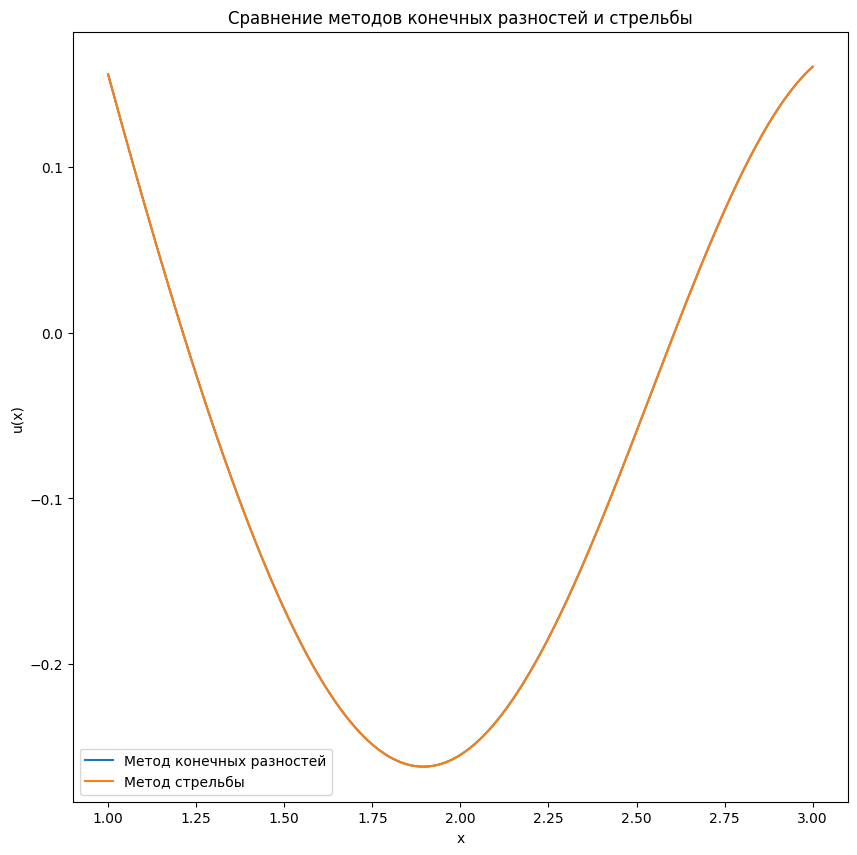

In [ ]:
fig = plt.figure(figsize=(10, 10))

plt.plot(grid, y_fdm, label='Метод конечных разностей')
plt.plot(grid, y_s, label='Метод стрельбы')

plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Сравнение методов конечных разностей и стрельбы')
plt.legend()

plt.show()

In [ ]:
df = pd.DataFrame({
    'Узел': grid,
    'Метод кон. раз.': y_fdm,
    'Метод стрельбы': y_s,
    'Модуль разности': y_dif
})
df.tail(10)

,Узел,Метод кон. раз.,Метод стрельбы,Модуль разности
19990,2.9991,0.160309,0.160336,0.000027
19991,2.9992,0.160328,0.160355,0.000027
19992,2.9993,0.160348,0.160374,0.000027
19993,2.9994,0.160367,0.160393,0.000027
19994,2.9995,0.160386,0.160413,0.000027
19995,2.9996,0.160405,0.160432,0.000027
19996,2.9997,0.160424,0.160451,0.000027
19997,2.9998,0.160444,0.160470,0.000027
19998,2.9999,0.160463,0.160489,0.000027
19999,3.0000,0.160482,0.160509,0.000027
